In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import scipy.special
import cv2

import torch

import networkx as nx

import pickle
from PIL import Image, ImageDraw
import matplotlib.lines as lines
from tqdm import tqdm
import glob

import statistics 

#For network adjacency checks
from skimage.transform import rotate
from sklearn.neighbors import KDTree
from scipy.spatial import distance

#For PCA
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as sns

import warnings

np.seterr(all='raise')
scipy.special.seterr(all='raise')

from lineage_timeless import lineage_timeless
from network_object import network_object
from cell_object import cell_object

In [2]:
globalpath = "/Volumes/TC_backup/SCC_YM/p1"

load_lineage_list_YM = []

for lineage_path in tqdm(sorted(glob.glob(globalpath+"/*.lineage")), position=0, leave=True, desc = globalpath):
    templineage = lineage_timeless(lineage_path[0:-8], lineage_path[0:-8], read=False)
    templineage.load_object(fin = lineage_path)
    if len(templineage.items) > 10:
        load_lineage_list_YM.append(templineage)
    
    
globalpath = "/Volumes/TC_backup/SCC_YMR/p1"

load_lineage_list_YMR = []

for lineage_path in tqdm(sorted(glob.glob(globalpath+"/*.lineage")), position=0, leave=True, desc = globalpath):
    templineage = lineage_timeless(lineage_path[0:-8], lineage_path[0:-8], read=False)
    templineage.load_object(fin = lineage_path)
    if len(templineage.items) > 10:
        load_lineage_list_YMR.append(templineage)

print(len(load_lineage_list_YM))
print(len(load_lineage_list_YMR))

/Volumes/TC_backup/SCC_YMR/p1: 100%|██████████| 96/96 [35:15<00:00, 22.04s/it]  


65
72


In [3]:
#lineage_list = load_lineage_list_YM[0:10] + load_lineage_list_YMR[0:10]
lineage_list = load_lineage_list_YM + load_lineage_list_YMR

lineage_list = [lineage for lineage in lineage_list if len(lineage.items)>0]

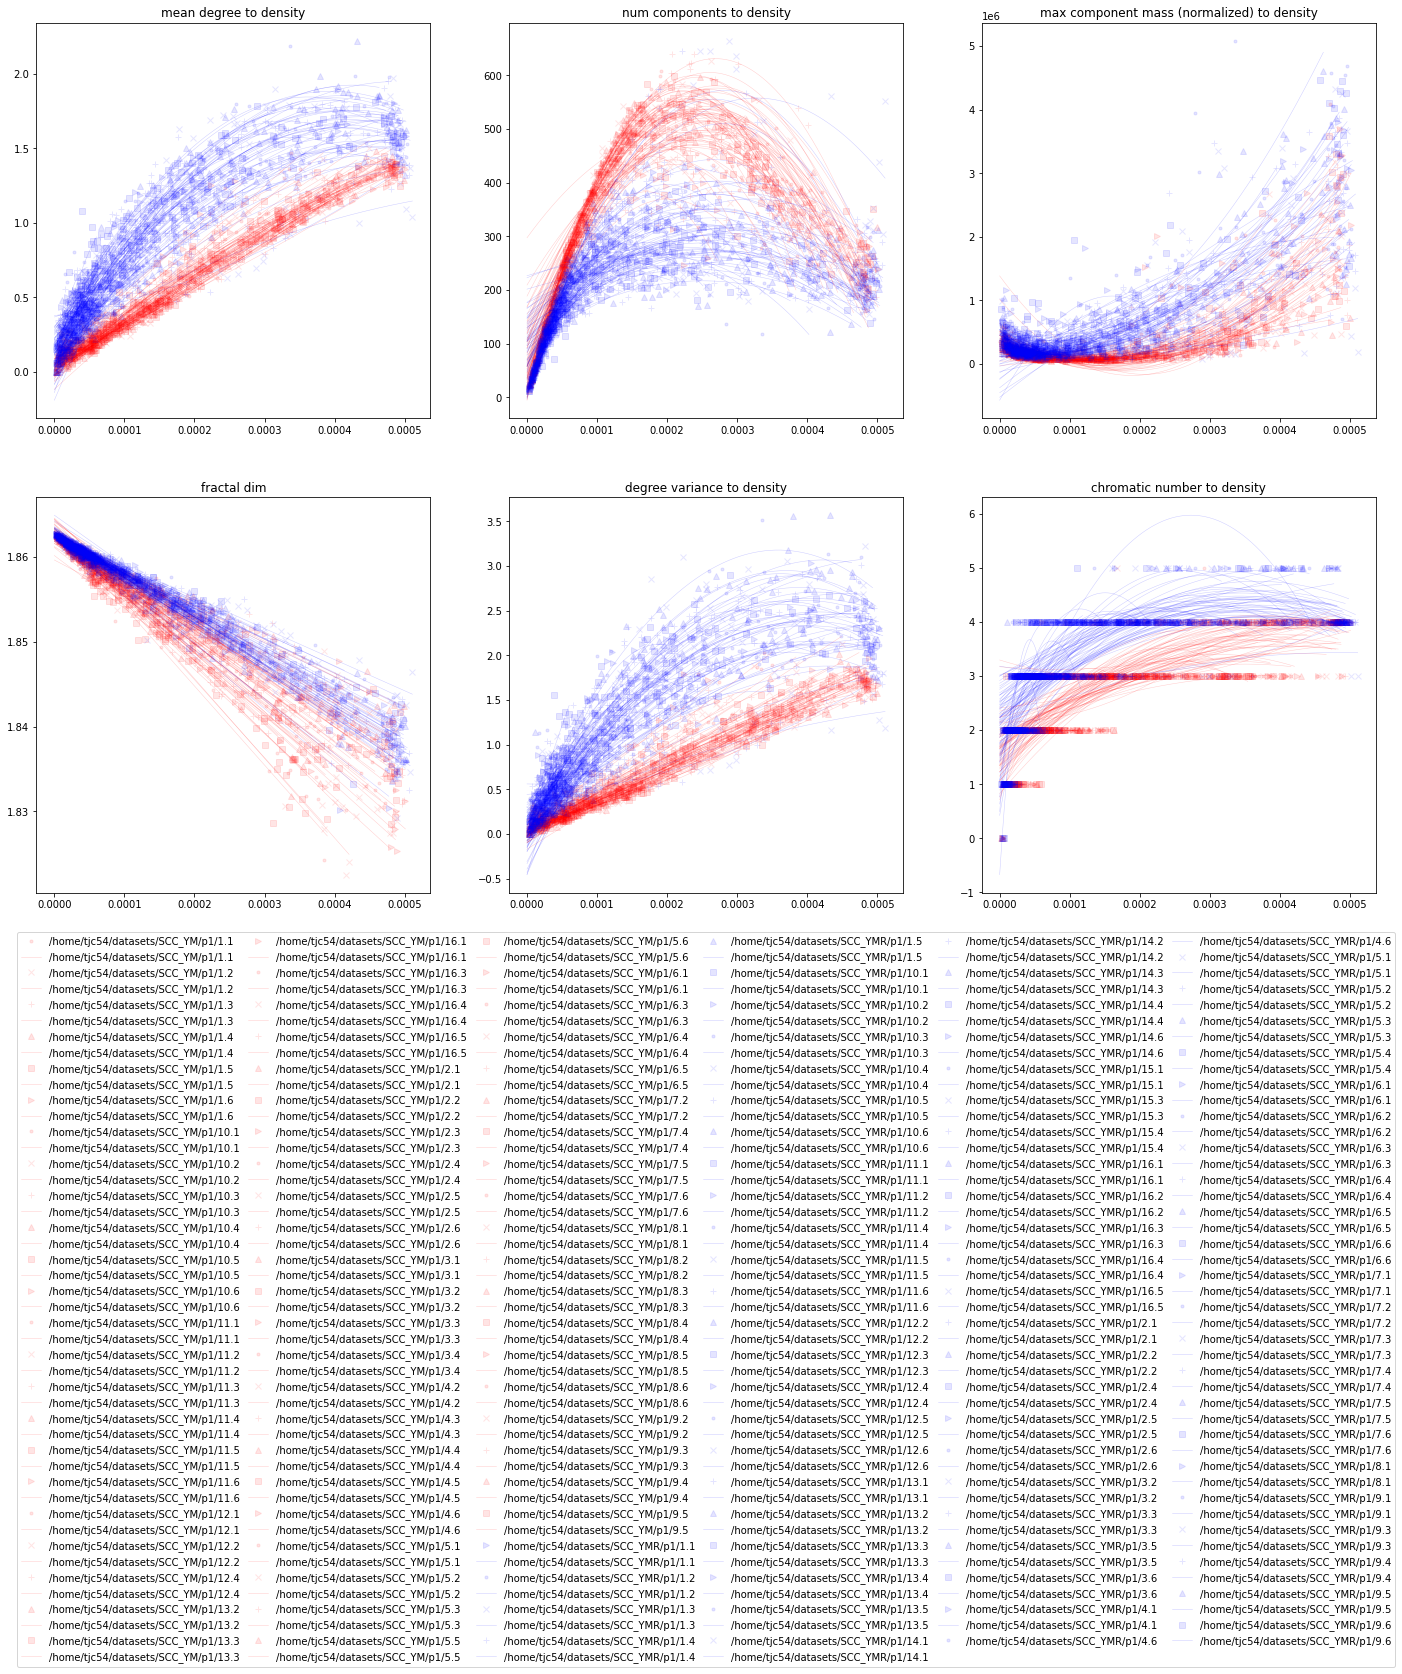

In [23]:
#//  NETWORK PROPS  //#

import itertools

plot = True

#if plot != False:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 16))
symbols = ['.','x','+','^','s','>']


#fitprops = []
ncomp0 = []
ncomp1 = []
ncomp2 = []
mdeg0 = []
mdeg1 = []
mdeg2 = []
mcompmass0 = []
mcompmass1 = []
mcompmass2 = []
fdim0 = []
fdim1 = []
cnum0 = []
cnum1 = []
cnum2 = []
degvar0 = []
degvar1 = []
degvar2 = []

temp = [0,0,0,0] #temporary


def polyfit_rough(xdata,ydata,pdegree = 1, plot = False, axes = None, color = None, label = "Fit function"):
    popt = np.polyfit(xdata, ydata, pdegree)#---------------------------------
    if plot != False:
        t = np.linspace(0, max(xdata), 1000)
        axes.plot(t, np.poly1d(popt)(t), label=label, color = color, linewidth = .5, alpha = 0.2)
    return popt

i = 0
ax1.set_title("mean degree to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    degree = [network.average_degree() for network in lineage.items]

    degree = [degree for _,degree in sorted(zip(density,degree))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax1.plot(density,degree, symbols[i%6], label = lineage.tag, color = color, alpha = 0.1)
    
    temp = polyfit_rough(density,degree,pdegree=2,axes = ax1, color = color, label = lineage.tag, plot = plot)
    mdeg0.append(temp[0])
    mdeg1.append(temp[1])
    mdeg2.append(temp[2])
    i += 1
#ax1.legend()

i = 0
ax2.set_title("num components to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    num_components = [network.num_components for network in lineage.items]

    num_components = [num_components for _,num_components in sorted(zip(density,num_components))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax2.plot(density,num_components, symbols[i%6], label = lineage.tag, color = color, alpha = 0.1)
    
    temp = polyfit_rough(density,num_components,pdegree=2,axes = ax2, color = color, label = lineage.tag, plot = plot)
    ncomp0.append(temp[0])
    ncomp1.append(temp[1])
    ncomp2.append(temp[2])
    i += 1
#ax2.legend()

i = 0
ax3.set_title("max component mass (normalized) to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    max_mass = [network.get_max_comp_mass() for network in lineage.items]

    max_mass = [max_mass for _,max_mass in sorted(zip(density,max_mass))]
    density = sorted(density)
    
    max_mass = np.divide(max_mass,density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax3.plot(density,max_mass, symbols[i%6], label = lineage.tag, color = color, alpha = 0.1)
    
    temp = polyfit_rough(density,max_mass,pdegree=2,axes = ax3, color = color, label = lineage.tag, plot = plot)
    mcompmass0.append(temp[0])
    mcompmass1.append(temp[1])
    mcompmass2.append(temp[2])
    i += 1
#ax3.legend()

i = 0
ax4.set_title("fractal dim")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    fractal_dim = [network.fractal_dim for network in lineage.items]

    fractal_dim = [fractal_dim for _,fractal_dim in sorted(zip(density,fractal_dim))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax4.plot(density,fractal_dim, symbols[i%6], label = lineage.tag, color = color, alpha = 0.1)
    
    temp = polyfit_rough(density,fractal_dim,pdegree=1,axes = ax4, color = color, label = lineage.tag, plot = plot)
    fdim0.append(temp[0])
    fdim1.append(temp[1])
    i += 1
#ax4.legend()

i = 0
ax5.set_title("degree variance to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    degree_var = [network.degree_variance() for network in lineage.items]

    degree_var = [degree_var for _,degree_var in sorted(zip(density,degree_var))]
    density = sorted(density)
    
    #degree_var = np.divide(degree_var,density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax5.plot(density,degree_var, symbols[i%6], label = lineage.tag, color = color, alpha = 0.1)
    
    temp = polyfit_rough(density,degree_var,pdegree=2,axes = ax5, color = color, label = lineage.tag, plot = plot)
    degvar0.append(temp[0])
    degvar1.append(temp[1])
    degvar2.append(temp[2])
    i += 1
ax5.legend(bbox_to_anchor=(-1.25, 0, 3.5, -.1), ncol=6, mode="expand", borderaxespad=0.)

i = 0
ax6.set_title("chromatic number to density")
for lineage in lineage_list:
    #tqdm(lineage_list, desc = "chromatic number", position=0, leave=True):
    density = [network.density for network in lineage.items]
    colornum = [network.calc_chromatic() for network in lineage.items]

    colornum = [colornum for _,colornum in sorted(zip(density,colornum))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax6.plot(density,colornum, symbols[i%6], label = lineage.tag, color = color, alpha = 0.1)
    
    temp = polyfit_rough(density,colornum,pdegree=2,axes = ax6, color = color, label = lineage.tag, plot = plot)
    cnum0.append(temp[0])
    cnum1.append(temp[1])
    cnum2.append(temp[2])
    i += 1
#ax6.legend()

plt.savefig("densityPlots_YM+YMR.png", dpi = 75)

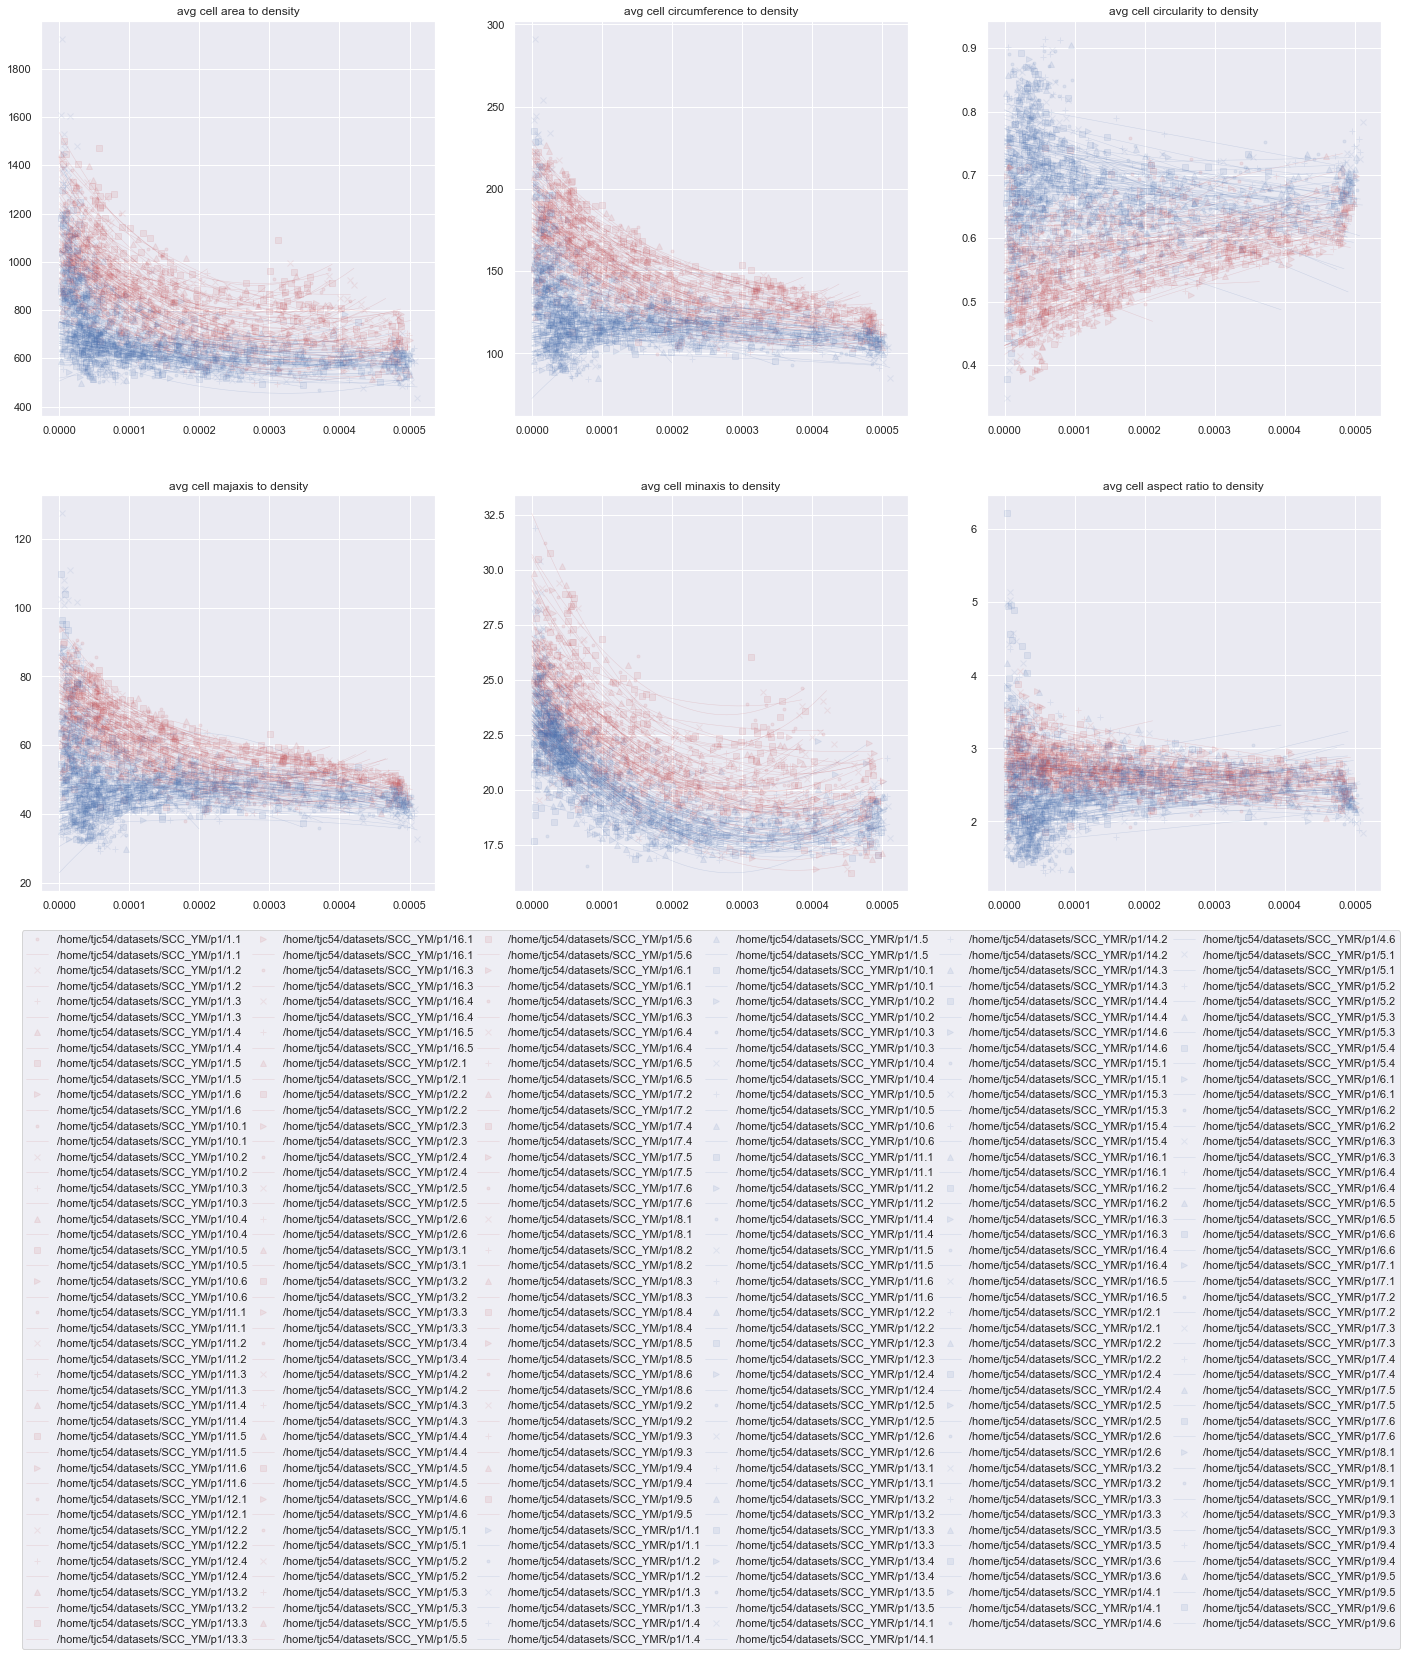

In [96]:
#//  SINGLE CELL PROPS  //#

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 16))
symbols = ['.','x','+','^','s','>']

plot = True

'''
#fitprops = []
Sarea = []
Scircum = []
circ0 = []
circ1 = []

temp = [0,0,0,0] #temporary
'''

#avg = lambda x: sum(x)/len(x)
def avg(x):
    return sum(x)/len(x)

def polyfit_rough(xdata,ydata,pdegree = 1, plot = False, axes = None, color = None, label = "Fit function"):
    popt = np.polyfit(xdata, ydata, pdegree)#---------------------------------
    if plot != False:
        t = np.linspace(0, max(xdata), 1000)
        axes.plot(t, np.poly1d(popt)(t), label=label, color = color, linewidth = .5, alpha = 0.2)
    return popt

i = 0
ax1.set_title("avg cell area to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    area = [avg(network.cell_areas) for network in lineage.items]

    area = [area for _,area in sorted(zip(density,area))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax1.plot(density,area, symbols[i%6], label = lineage.tag, color = color, alpha = 0.1)
    
    temp = polyfit_rough(density,area,pdegree=2,axes = ax1, color = color, label = lineage.tag, plot = plot)
    #mdeg0.append(temp[0])
    #mdeg1.append(temp[1])
    #mdeg2.append(temp[2])
    i += 1

i = 0
ax2.set_title("avg cell circumference to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    circum = [avg(network.cell_perimeters) for network in lineage.items]

    circum = [circum for _,circum in sorted(zip(density,circum))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax2.plot(density,circum, symbols[i%6], label = lineage.tag, color = color, alpha = 0.1)
    
    temp = polyfit_rough(density,circum,pdegree=2,axes = ax2, color = color, label = lineage.tag, plot = plot)
    #ncomp0.append(temp[0])
    #ncomp1.append(temp[1])
    #ncomp2.append(temp[2])
    i += 1
#ax2.legend()

i = 0
ax3.set_title("avg cell circularity to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    circul = [avg(network.cell_circularities) for network in lineage.items]

    circul = [circul for _,circul in sorted(zip(density,circul))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax3.plot(density,circul, symbols[i%6], label = lineage.tag, color = color, alpha = 0.1)
    
    temp = polyfit_rough(density,circul,pdegree=1,axes = ax3, color = color, label = lineage.tag, plot = plot)
    #mcompmass0.append(temp[0])
    #mcompmass1.append(temp[1])
    #mcompmass2.append(temp[2])
    i += 1
#ax3.legend()

i = 0
ax4.set_title("avg cell majaxis to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    majax = [avg(network.cell_majaxes) for network in lineage.items]

    majax = [majax for _,majax in sorted(zip(density,majax))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax4.plot(density,majax, symbols[i%6], label = lineage.tag, color = color, alpha = 0.1)
    
    temp = polyfit_rough(density,majax,pdegree=2,axes = ax4, color = color, label = lineage.tag, plot = plot)
    #fdim0.append(temp[0])
    #fdim1.append(temp[1])
    i += 1
#ax4.legend()

i = 0
ax5.set_title("avg cell minaxis to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    minax = [avg(network.cell_minaxes) for network in lineage.items]

    minax = [minax for _,minax in sorted(zip(density,minax))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax5.plot(density,minax, symbols[i%6], label = lineage.tag, color = color, alpha = 0.1)
    
    temp = polyfit_rough(density,minax,pdegree=2,axes = ax5, color = color, label = lineage.tag, plot = plot)
    #degvar0.append(temp[0])
    #degvar1.append(temp[1])
    #degvar2.append(temp[2])
    i += 1
ax5.legend(bbox_to_anchor=(-1.25, 0, 3.5, -.1), ncol=6, mode="expand", borderaxespad=0.)


i = 0
ax6.set_title("avg cell aspect ratio to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    
    asra = [avg(network.cell_majaxes)/avg(network.cell_minaxes) for network in lineage.items]
    asra = [asra for _,asra in sorted(zip(density,asra))]

    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax6.plot(density,asra, symbols[i%6], label = lineage.tag, color = color, alpha = 0.1)
    
    temp = polyfit_rough(density,asra,pdegree=1,axes = ax6, color = color, label = lineage.tag, plot = plot)
    #degvar0.append(temp[0])
    #degvar1.append(temp[1])
    #degvar2.append(temp[2])
    i += 1
plt.savefig("SingleCellProps_densityPlots_YM+YMR.png", dpi = 75)



In [46]:
#///   LOAD TO PANDAS DF   ///#

import pandas as pd
'''
each lineage has:

lineage

3 fit params for num components:
    ncomp0 ncomp1 ncomp2
    
2 fit params for mean degree (normalized):
    mdeg0 mdeg1
    
3 fit params for max comp mass (normalized):
    mcompmass0 mcompmass1 mcompmass2
    
2 fit params for fractal dimension:
    fdim0 fdim1
    
2 fit params for chromatic number:
    cnum0 cnum1
    
2 fit params for degree variance:
    degvar0 degvar1
    
'''

#Creating the dataframe

l_tags = [lineage.tag for lineage in lineage_list]


objs = {
    'lineage':l_tags,
    'ncomp0':ncomp0,
    'ncomp1':ncomp1, 
    'ncomp2':ncomp2, 
    'mdeg0':mdeg0, 
    'mdeg1':mdeg1, 
    'mcompmass0':mcompmass0, 
    'mcompmass1':mcompmass1, 
    'mcompmass2':mcompmass2, 
    'fdim0':fdim0, 
    'fdim1':fdim1, 
    'cnum0':cnum0, 
    'cnum1':cnum1, 
    'degvar0':degvar0, 
    'degvar1':degvar1,
}

'''
Additional OBJS:
'''
ncomp0 = np.array(ncomp0)
ncomp1 = np.array(ncomp1)
ncomp2 = np.array(ncomp2)
mdeg0 = np.array(mdeg0)
mdeg1 = np.array(mdeg1)
mdeg2 = np.array(mdeg2)
mcompmass0 = np.array(mcompmass0)
mcompmass1 = np.array(mcompmass1)
mcompmass2 = np.array(mcompmass2)
fdim0 = np.array(fdim0)
cnum0 = np.array(cnum0)
cnum1 = np.array(cnum1)
cnum2 = np.array(cnum2)

hdensity = 0.0004
ldensity = 0.00015

#num components apex:
ncomph = -ncomp1/(2*ncomp0)                       #x coord of vertex
ncompk = ncomp2 - (ncomp1*ncomp1/(4*ncomp0))      #y coord of vertex

#(relative) max component mass:
mcompmass_h = mcompmass0*(hdensity*hdensity)+mcompmass1*(hdensity)+mcompmass2  #y value calculated at x=0.0004
mcompmass_d = 2*mcompmass0*(hdensity)+mcompmass1                           #y' value calculated at x=0.0004
    
#fractal dimension:
fdim0  #slope only, constant not needed as all converge to same value with very few objects
    
#mean degree / degree variance:
  #as K-degree and variance in degree are highly correlated, and likely simply scale linearly, here omit degvar
mdeg_l = mdeg0*(ldensity*ldensity)+mdeg1*(ldensity)+mdeg2  #y value calculated at x=0.00015
dmdeg_l = 2*mdeg0*(ldensity)+mdeg1                      #y' value calculated at x=0.0004
mdeg_h = mdeg0*(hdensity*hdensity)+mdeg1*(hdensity)+mdeg2     #y value calculated at x=0.00015
dmdeg_h = 2*mdeg0*(hdensity)+mdeg1                       #y' value calculated at x=0.0004
    
#chromatic number:
cnumh = -cnum1/(2*cnum0)                    #x coord of vertex
cnumk = cnum2 - (cnum1*cnum1/(4*cnum0))     #y coord of vertex




add_objs = {
    'lineage':l_tags,
    'ncomph':ncomph,
    'ncompk':ncompk, 
    'mdeg_l':mdeg_l, 
    'dmdeg_l':dmdeg_l,
    'mdeg_h':mdeg_h, 
    'dmdeg_h':dmdeg_h,
    'mcompmass_h':mcompmass_h, 
    'mcompmass_d':mcompmass_d, 
    'fdim0':fdim0, 
    'cnumh':cnumh, 
    'cnumk':cnumk, 
}

def choose_color(lineage):
    if "YM/" in lineage:
        return "r"
    if "YMR/" in lineage:
        return "b"
    
#df = pd.DataFrame(objs)
df = pd.DataFrame(add_objs)

#df['line'] = [choose_color(lineage[0]) for lineage in y]


In [29]:
#///   PCA   ///#

#Property Standardization

'''features = ['ncomp0', 'ncomp1', 'ncomp2', 
           'mdeg0', 'mdeg1', 
           'mcompmass0', 'mcompmass1', 'mcompmass2', 
           'fdim0', 'fdim1', 
           'cnum0', 'cnum1', 
           'degvar0', 'degvar1']
'''

features =  ['ncomph', 'ncompk', 'mdeg_l', 
    'dmdeg_l','mdeg_h', 'dmdeg_h',
    'mcompmass_h', 'mcompmass_d', 'fdim0', 
    'cnumh', 'cnumk', ]

x = df.loc[:, features].values
y = df.loc[:,['lineage']].values
x = StandardScaler().fit_transform(x)

#PCA Projection

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])

finalDf = pd.concat([principalDf, df[['lineage']]], axis = 1)

EVR = pca.explained_variance_ratio_

print(EVR)
print(sum(EVR))

[0.40802495 0.19850468 0.1783564  0.11904582 0.06184865]
0.965780491959887


  0%|          | 1/360 [00:02<14:41,  2.46s/it]


SystemError: <built-in method write of _io.BufferedWriter object at 0x24ecbd590> returned a result with an error set

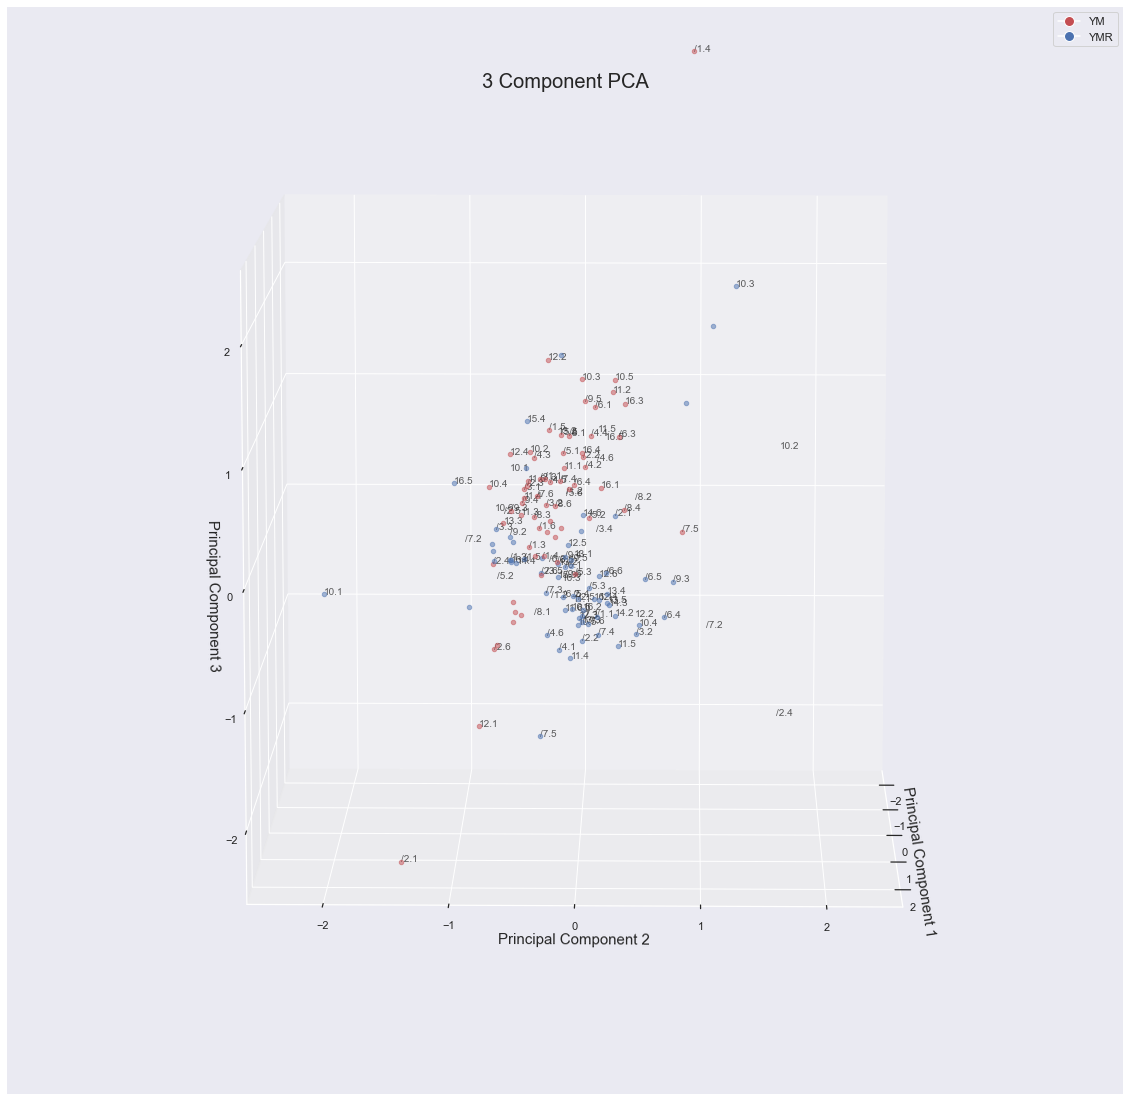

In [30]:
from mpl_toolkits import mplot3d
from matplotlib.lines import Line2D

#Visualizer

#fig, ax1 = plt.subplots(1, 1, figsize=(30, 8))
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(111, projection='3d')

ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_zlabel('Principal Component 3', fontsize = 15)
ax1.set_title('3 Component PCA', fontsize = 20)

ax1.axes.set_xlim3d(left=-2.5, right=2.5) 
ax1.axes.set_ylim3d(bottom=-2.5, top=2.5) 
ax1.axes.set_zlim3d(bottom=-2.5, top=2.5) 


symbols = ['.','x','+','^','o',]

for i in range(len(finalDf)):
    indicesToKeep = finalDf['lineage'] == lineage
    #color=next(ax6._get_lines.prop_cycler)['color']
    if "YM/" in finalDf.at[i, 'lineage']:
        color = "r"
    if "YMR/" in finalDf.at[i, 'lineage']:
        color = "b"
    ax1.scatter3D(finalDf.at[i, 'pc1']
          , finalDf.at[i, 'pc2']
          , finalDf.at[i, 'pc3']
          , symbols[i%5], color = color
          , alpha = 0.5)
    ax1.text(finalDf.at[i, 'pc1'],finalDf.at[i, 'pc2'],finalDf.at[i, 'pc3'] ,  finalDf.at[i,'lineage'][-4:], size=10, alpha = 0.7,  color='k') 

    
legend_elements = [Line2D([0], [0], marker='o', color='w', label='YM',
                          markerfacecolor='r', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='YMR',
                          markerfacecolor='b', markersize=10),]
ax1.legend(handles=legend_elements)
    
    
    
for ii in tqdm(range(0,360,1)):
    ax1.view_init(elev=10., azim=ii)
    plt.savefig("movie_pca/movie%d.png" % ii)
        
#plt.savefig("2 Component PCA.png", dpi = 75)

In [188]:
#///   UMAP   ///#

import umap

#FOR out dimensionality
n_components = 2

reducer = umap.UMAP(n_components = n_components)

#Property Standardization

'''features = ['ncomp0', 'ncomp1', 'ncomp2', 
           'mdeg0', 'mdeg1', 
           'mcompmass0', 'mcompmass1', 'mcompmass2', 
           'fdim0', 'fdim1', 
           'cnum0', 'cnum1', 
           'degvar0', 'degvar1']
'''
features =  ['ncomph', 'ncompk', 'mdeg_l', 
    'dmdeg_l','mdeg_h', 'dmdeg_h',
    'mcompmass_h', 'mcompmass_d', 'fdim0', 
    'cnumh', 'cnumk', ]

x = df.loc[:, features].values
y = df.loc[:,['lineage']].values
df['line'] = [choose_color(lineage[0]) for lineage in y]
x = StandardScaler().fit_transform(x)

embedding = reducer.fit_transform(x)
embedding.shape

AttributeError: module 'numba' has no attribute 'core'

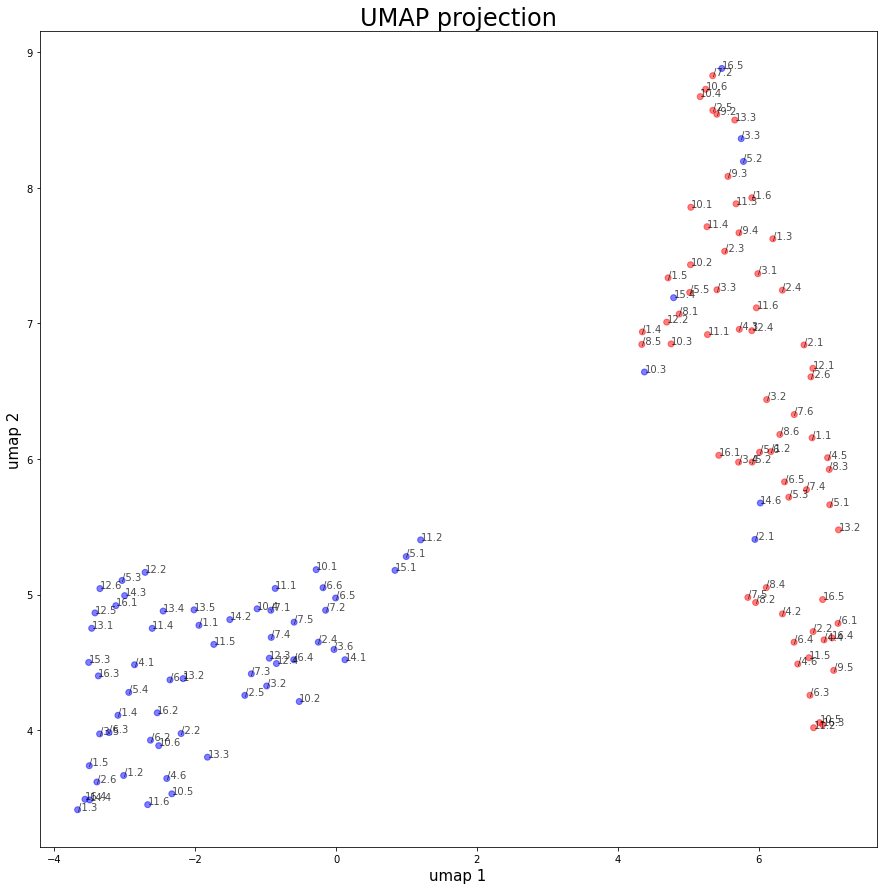

In [115]:
def choose_color(lineage):
    if "YM/" in lineage:
        return "r"
    if "YMR/" in lineage:
        return "b"

if n_components == 2:
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(111)

    ax1.set_xlabel('umap 1', fontsize = 15)
    ax1.set_ylabel('umap 2', fontsize = 15)
    ax1.set_title('UMAP projection', fontsize=24)

    ax1.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=[choose_color(lineage[0]) for lineage in y],
        alpha = 0.5)
    for i in range(len(embedding)):
        ax1.text(embedding[i][0],embedding[i][1], df['lineage'][i][-4:], size=10, alpha = 0.7,  color='k') 
    plt.savefig("umap_2D.png")
    
if n_components == 3:
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(111, projection='3d')

    ax1.set_xlabel('umap 1', fontsize = 15)
    ax1.set_ylabel('umap 2', fontsize = 15)
    ax1.set_zlabel('umap 3', fontsize = 15)
    ax1.set_title('UMAP projection', fontsize=24)

    ax1.scatter(
        embedding[:, 0],
        embedding[:, 1],
        embedding[:, 2],
        c=[choose_color(lineage[0]) for lineage in y],
        alpha = 0.5)
    for i in range(len(embedding)):
        ax1.text(embedding[i][0],embedding[i][1],embedding[i][2], df['lineage'][i][-4:], size=10, alpha = 0.7,  color='k') 
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='YM',
                          markerfacecolor='r', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='YMR',
                          markerfacecolor='b', markersize=10),]
    ax1.legend(handles=legend_elements)
    
    for ii in tqdm(range(0,360,1)):
        ax1.view_init(elev=10., azim=ii)
        plt.savefig("movie_umap/movie%d.png" % ii)

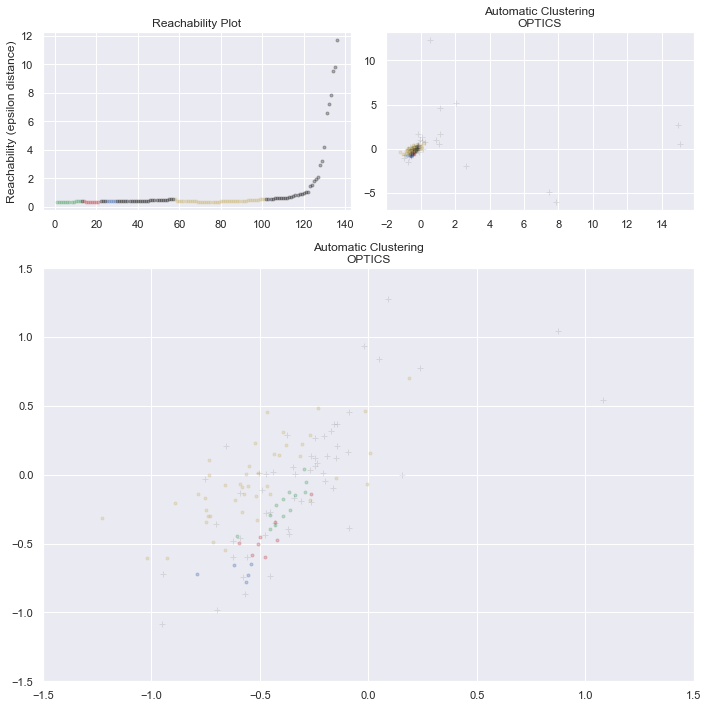

In [34]:
#CLUSTERING PCA with OPTICS
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

pca_outs = np.array([[finalDf.at[i, 'pc1'], finalDf.at[i, 'pc2'], finalDf.at[i, 'pc3'], finalDf.at[i,'pc4']] for i in range(len(finalDf))])
X = pca_outs

clust = OPTICS(min_samples=9, xi=.0001, min_cluster_size=.03)

clust.fit(X)


space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10,10))
G = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(G[0, 0])
ax2 = plt.subplot(G[0, 1])
ax3 = plt.subplot(G[1:, :])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Automatic Clustering\nOPTICS')
ax3.axes.set_xlim([-1.5,1.5])
ax3.axes.set_ylim([-1.5,1.5])

plt.tight_layout()
plt.savefig("OPTICS_clustering.png")
plt.show()

[3, 10, 13, 24, 27, 48, 59, 70, 72, 77, 91, 96, 112, 115, 132]


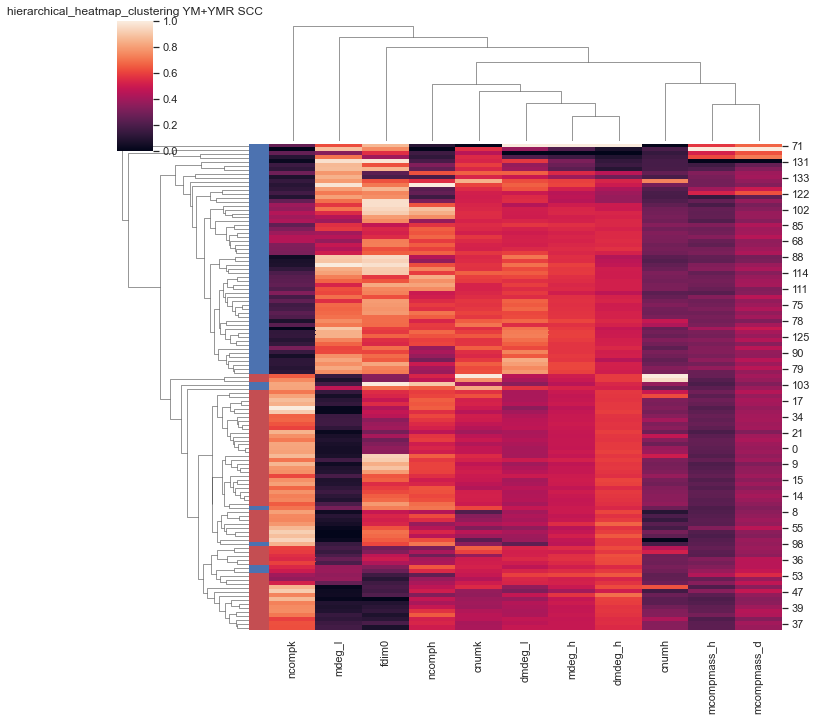

In [187]:
#Hierarchical heatmap clustering:
#Outlier exclusion based on Z-Score Thresholding:

from scipy import stats
sns.set_theme(color_codes=True)


testdf = df.copy(deep=True)


testdf.pop('lineage')
z = np.abs(stats.zscore(testdf))

threshold = 2
print(list(dict.fromkeys(np.where(z>threshold)[0].tolist())))
testdf = testdf.drop(list(dict.fromkeys(np.where(z>threshold)[0].tolist())))

YM_indexlist = [i for i in testdf.index if "YM/" in df.iloc[i]['lineage']]
YMR_indexlist = [i for i in testdf.index if "YMR/" in df.iloc[i]['lineage']]
row_colors = []
for i in range(len(YM_indexlist)):
    row_colors.append('r')
for i in range(len(YMR_indexlist)):
    row_colors.append('b')

g = sns.clustermap(testdf,standard_scale=1,row_colors=row_colors)
plt.title("hierarchical_heatmap_clustering YM+YMR SCC")
plt.savefig("hierarchical_heatmap_clustering.png",dpi=75)

[3, 10, 13, 24, 27, 48, 59, 70, 72, 77, 91, 96, 112, 115, 132]


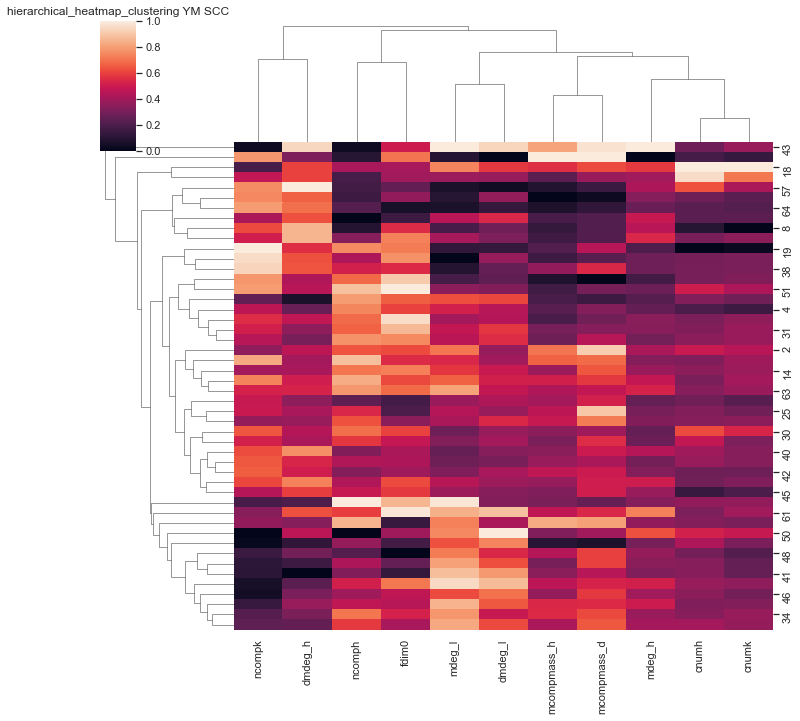

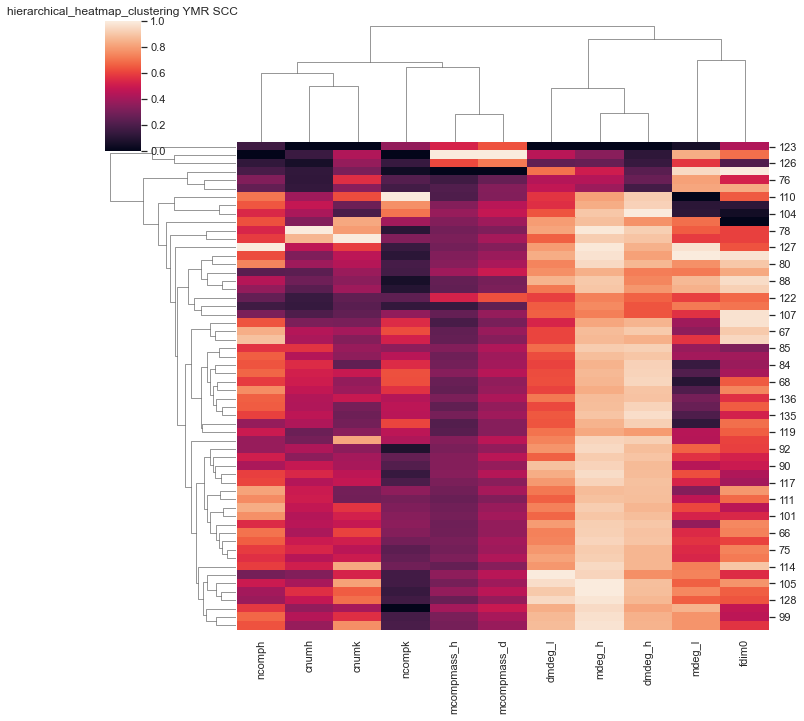

In [168]:
testdf = df.copy(deep=True)

testdf.pop('lineage')

threshold = 2
print(list(dict.fromkeys(np.where(z>threshold)[0].tolist())))
#testdf = testdf.drop(list(dict.fromkeys(np.where(z>threshold)[0].tolist())))

YM_indexlist = [i for i in range(len(df)) if "YM/" in df.iloc[i]['lineage']]
YMR_indexlist = [i for i in range(len(df)) if "YMR/" in df.iloc[i]['lineage']]

ym_tester = testdf.iloc[YM_indexlist]
ymr_tester = testdf.iloc[YMR_indexlist]

ym_tester = ym_tester.drop(list(dict.fromkeys(np.where(np.abs(stats.zscore(ym_tester))>threshold)[0].tolist())))
ymr_tester = ymr_tester.drop(list(dict.fromkeys([i+min(ymr_tester.index) for i in np.where(np.abs(stats.zscore(ymr_tester))>threshold)[0]])))
ymr_tester = ymr_tester.drop([70]) ##Questionable, but index 70 seems to throw things off somewhat !

g = sns.clustermap(ym_tester,standard_scale=1)
plt.title("hierarchical_heatmap_clustering YM SCC")
plt.savefig("hierarchical_heatmap_clustering_YM.png",dpi=75)
g = sns.clustermap(ymr_tester,standard_scale=1)
plt.title("hierarchical_heatmap_clustering YMR SCC")
plt.savefig("hierarchical_heatmap_clustering_YMR.png",dpi=75)

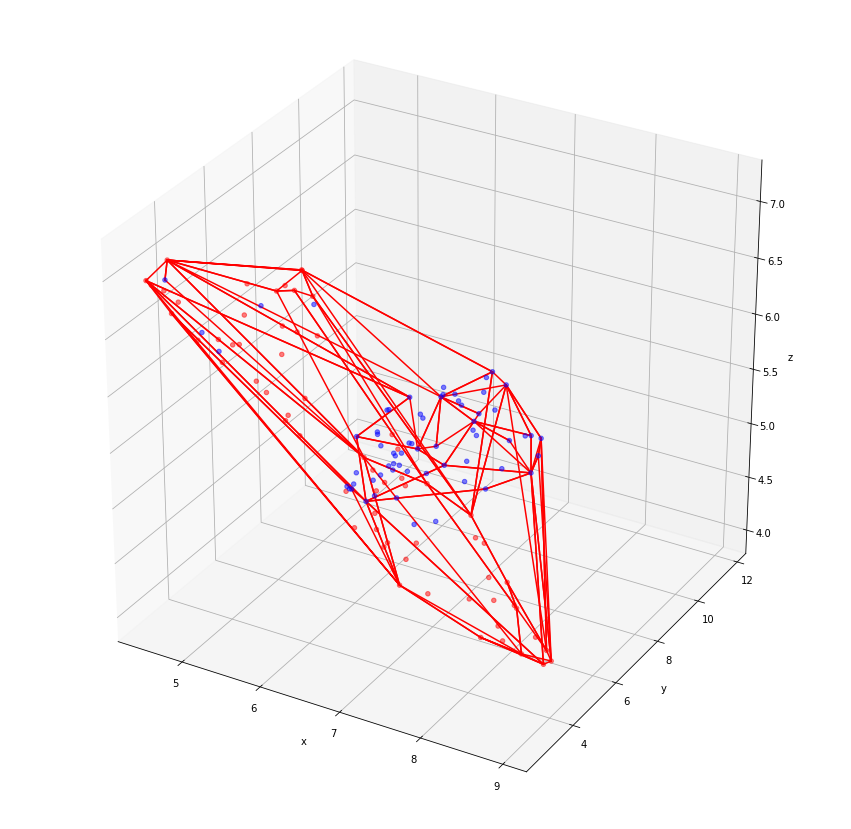

In [60]:
#TRY - TEMP

from scipy.spatial import ConvexHull
hull = ConvexHull(embedding)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

edges= zip(*embedding)

for i in hull.simplices:
    plt.plot(embedding[i,0], embedding[i,1], embedding[i,2], 'r-')

ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        embedding[:, 2],
        c=[choose_color(lineage[0]) for lineage in y],
        alpha = 0.5) 

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

/Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


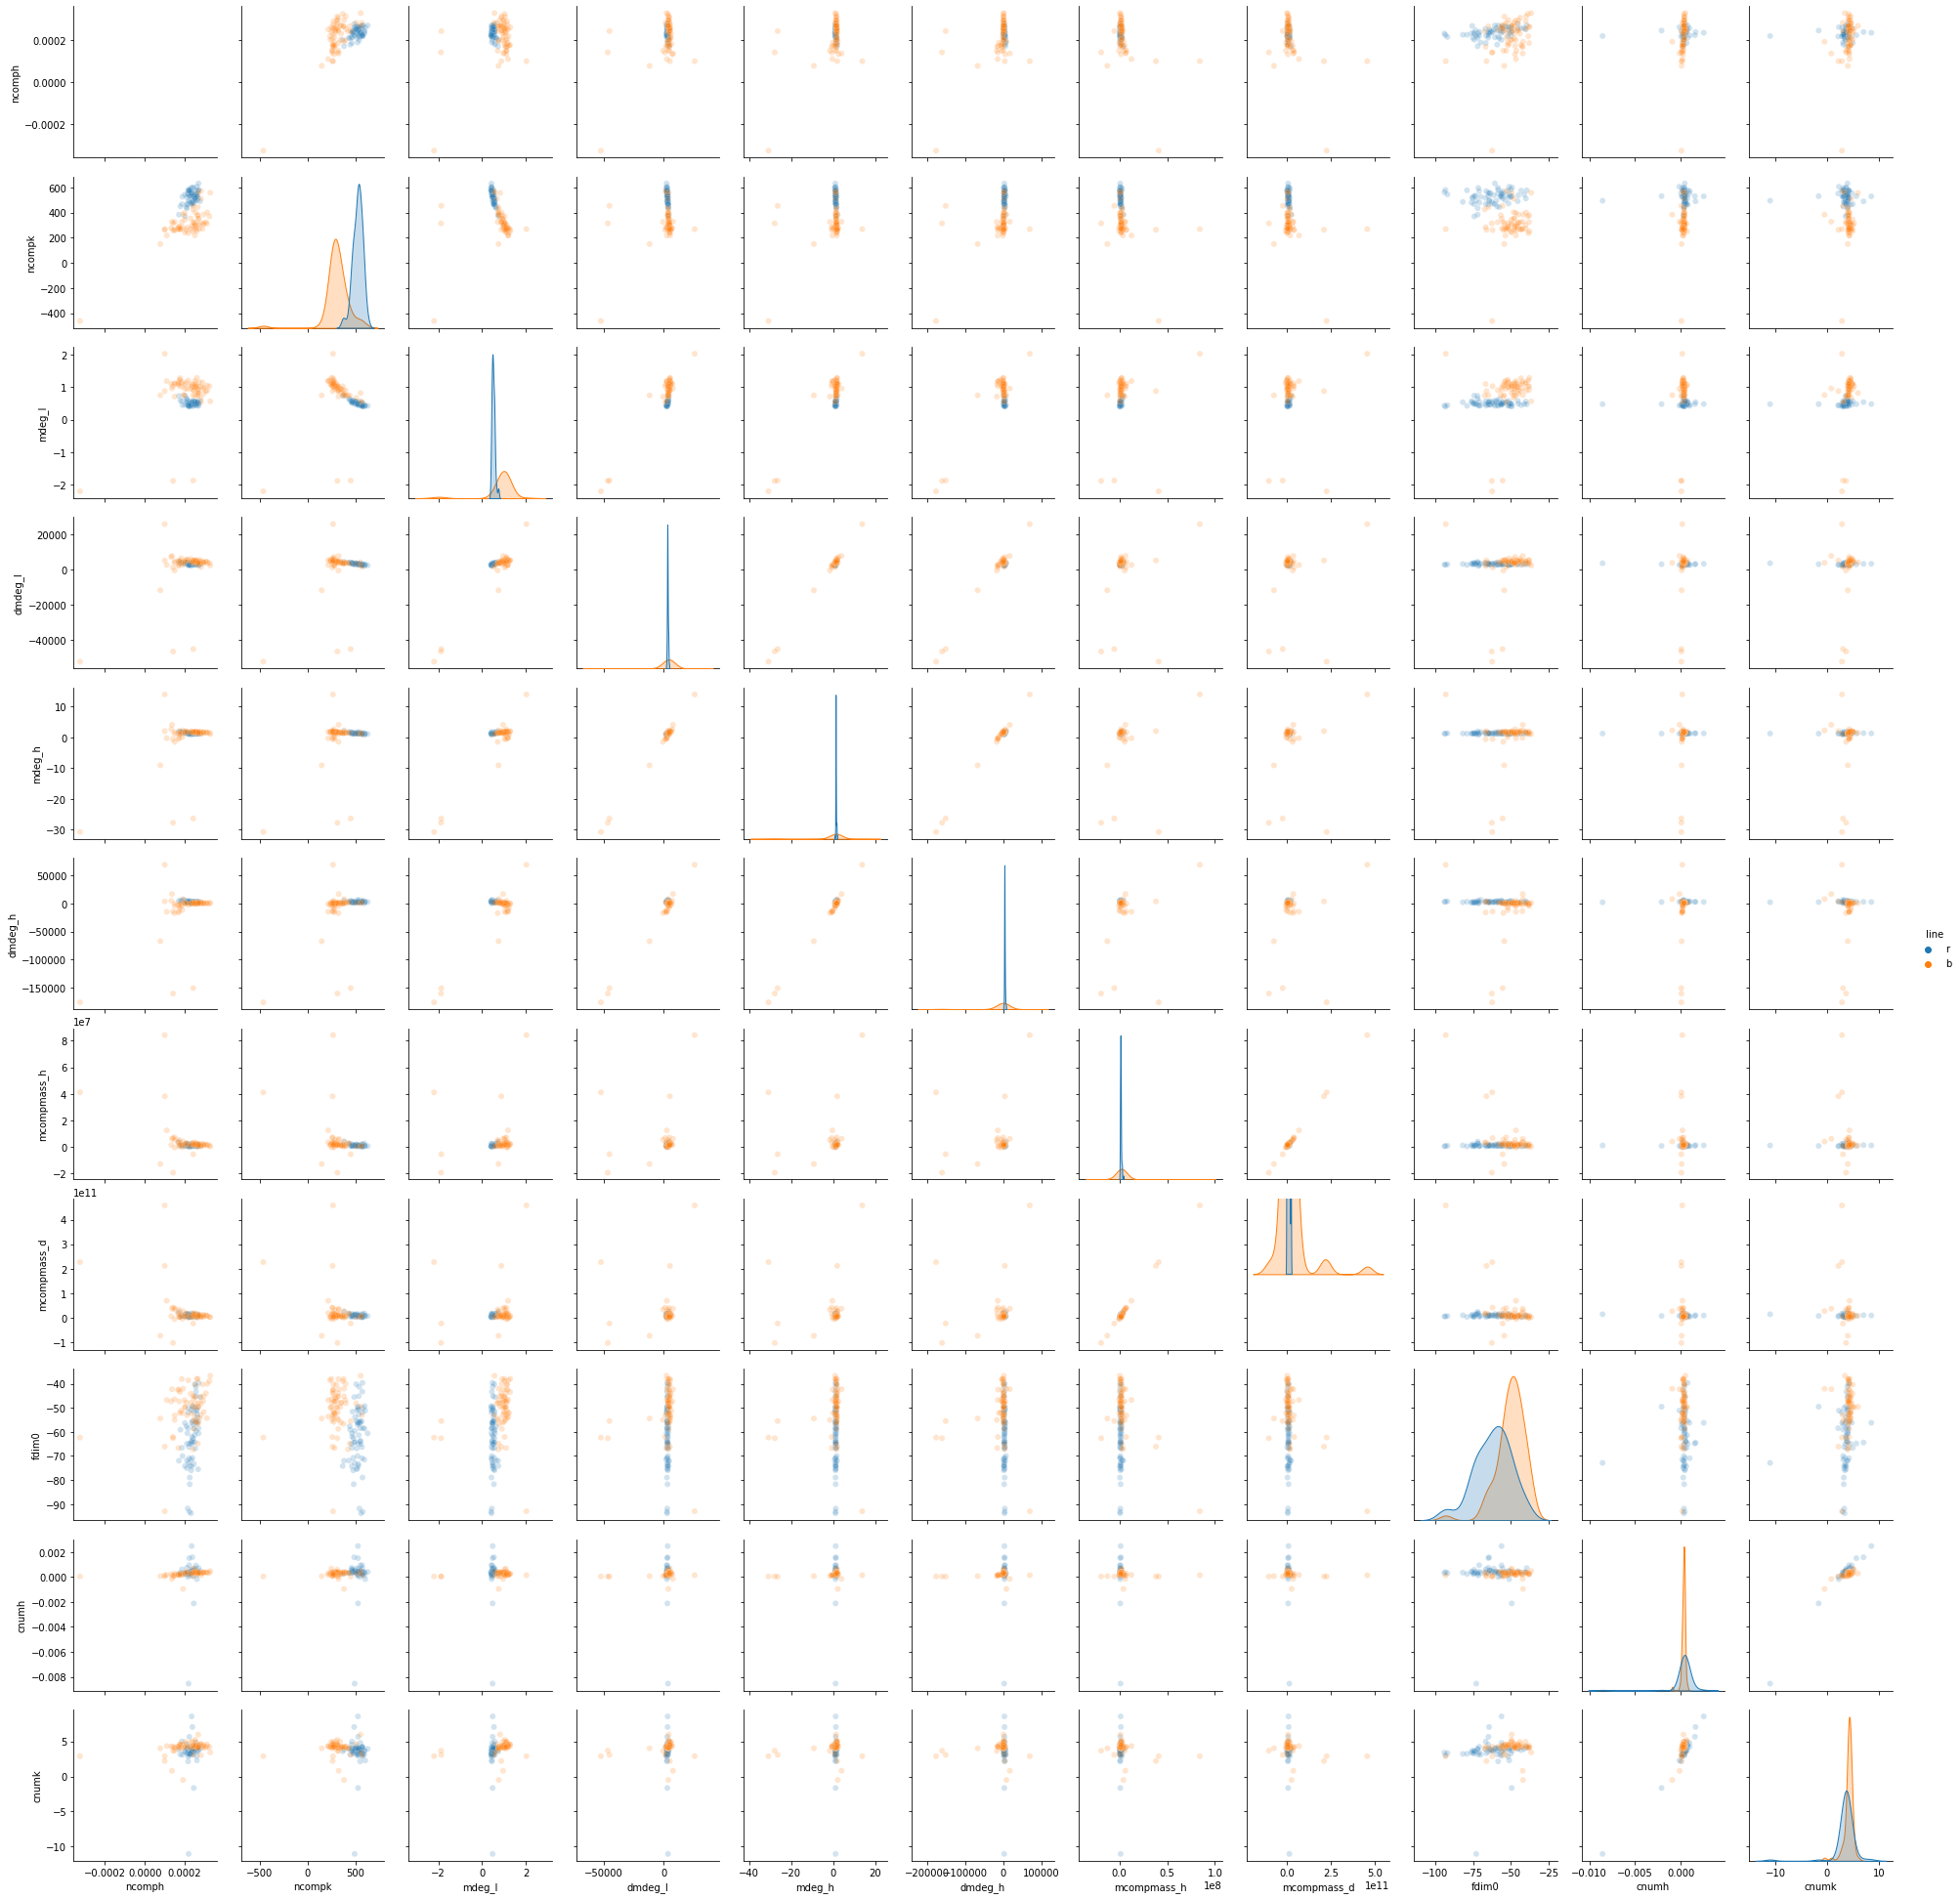

In [117]:
sns.pairplot(df, hue='line', plot_kws={'alpha':0.2})
plt.savefig("linvar_heatmap.png")

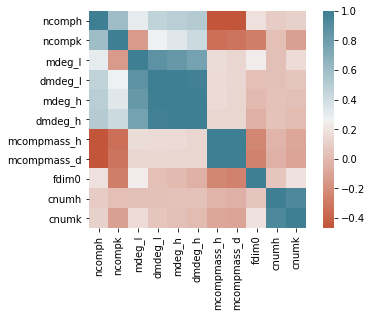

In [116]:
# plot the heatmap
sns.heatmap(df.corr(), 
           cmap=sns.diverging_palette(20, 220, n=200),
           square=True,
           )
plt.savefig("linvar_heatmap.png")

In [28]:
lineage_path = "/Volumes/TC_backup/SCC_YM/p1/1.1"
out_lineage = lineage_timeless(lineage_path, lineage_path, calc_fdim = False)

/Volumes/TC_backup/SCC_YM/p1/1.1: 100%|██████████| 20/20 [01:24<00:00,  4.23s/it]

load failed for /Volumes/TC_backup/SCC_YM/p1/1.1/MC176229_instances.data


In [32]:
dir(out_lineage.items[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'adjacency_list',
 'average_degree',
 'avgscore',
 'calc_chromatic',
 'calc_entropy',
 'calc_fractal_dim',
 'cell_areas',
 'cell_circularities',
 'cell_list',
 'cell_majaxes',
 'cell_minaxes',
 'cell_perimeters',
 'cell_scores',
 'centroid_list',
 'construct_adjacencies',
 'construct_centroid_list',
 'construct_graph',
 'construct_polygon_list',
 'degree_variance',
 'density',
 'densityHistogram',
 'fit_power',
 'fractal_dim',
 'get_component_masses',
 'get_largest_comp_ratio',
 'get_max_comp_mass',
 'graph',
 'image',
 'instances',
 'num_components',
 'number',
 'pickle_object',
 'plot_degree',
 'tag',
 'visualize_adjace